In [345]:
import torch
from transformers import CLIPProcessor, CLIPModel
from faker import Faker
import numpy as np
from tqdm import tqdm
import os
import torch

In [346]:
qdrant_api_token_one = os.getenv("QDRANT_TEST_ONE")

In [348]:
qdrant_api_token_two = os.getenv("QDRANT_TEST_TWO")

In [378]:
qdrant_cluster_a = os.getenv("qdrant_cluster_a")

In [379]:
qdrant_cluster_b = os.getenv("qdrant_cluster_b")

In [398]:
QDRANT_CLUSTER_NODES_cluster_a = os.getenv("QDRANT_CLUSTER_NODES").split(",")

In [381]:
NEW_QDRANT_CLUSTER_NODES_cluster_b = os.getenv("NEW_QDRANT_CLUSTER_NODES_cluster_b").split(",")

# Generate fake data

In [314]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [315]:
model.eval()
torch.no_grad()

In [22]:
fake = Faker()

In [23]:
record = {
    'brand': fake.company(),
    'model': fake.word(),
    'color': fake.color_name(),
    'storage': f"{fake.random_int(64, 512)} GB",
    'condition': fake.random_element(['New', 'Used', 'Refurbished']),
    'price': round(fake.random_number(digits=3), 2),
    'city': fake.city(),
    'description': fake.sentence(),
    'id': fake.uuid4()
    }

In [28]:
def generate_text(record):
    fields = [
        f"brand: {record.get('brand', 'N/A')}"
        f"Model: {record.get('model', 'N/A')}",
        f"color: {record.get('color', 'N/A')}",
        f"storage: {record.get('storage', 'N/A')}",
        f"condition: {record.get('condition', 'N/A')}",
        f"price: ${record.get('price', 'N/A')}",
        f"city: {record.get('city', 'N/A')}",
        f"description: {record.get('description', '')}"
    ]
    return ". ".join(fields)

In [193]:
generate_text(record).lower()

'brand: levine, beasley and reesemodel: indeed. color: slateblue. storage: 199 gb. condition: refurbished. price: $752. city: melissafurt. description: method morning mention between oil carry special.'

In [30]:
# Function to generate a single embedding
def generate_embedding(fields_concat):
    inputs = processor(text=fields_concat, images=None, return_tensors="pt", padding=True)
    outputs = model.get_text_features(**inputs)
    return outputs.detach().numpy().flatten()

In [32]:
indexed_vectors = []

# Number of vectors and points
num_vectors = 150_000

In [33]:
for _ in tqdm(range(num_vectors), desc="Generating indexed vectors"):
    # Create a randomized record similar to the provided format using Faker
    record = {
        'brand': fake.company(),
        'model': fake.word(),
        'color': fake.color_name(),
        'storage': f"{fake.random_int(64, 512)} GB",
        'condition': fake.random_element(['New', 'Used', 'Refurbished']),
        'price': round(fake.random_number(digits=3), 2),
        'city': fake.city(),
        'description': fake.sentence(),
        'id': fake.uuid4()
    }
    text = generate_text(record)
    embedding = generate_embedding(text)
    indexed_vectors.append({"id": record['id'], "vector": embedding, "record": record})

Generating indexed vectors: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 150000/150000 [35:04<00:00, 71.27it/s]


In [237]:
indexed_vectors[2]

{'id': 'fc329261-cf7d-47e4-af56-c2813aa3dd14',
 'vector': array([ 2.79945612e-01,  7.82234594e-02, -5.16451597e-02,  9.28873196e-02,
        -1.60017028e-01,  1.14933670e-01, -3.60503495e-02,  8.09278488e-02,
        -9.73841473e-02,  2.53643692e-01, -3.65928948e-01,  3.04550171e-01,
        -8.09966177e-02, -2.31350139e-02,  2.70407528e-01,  1.09564736e-01,
         1.46853670e-01,  3.36242646e-01,  1.42204061e-01,  1.38935745e-01,
         2.12107569e-01, -2.53344208e-01, -4.53289747e-02, -2.50389338e-01,
        -2.25602806e-01, -3.68206143e-01,  1.35281369e-01, -3.84590834e-01,
        -1.44583330e-01, -1.29207373e-01,  3.48217487e-01,  3.08986679e-02,
        -5.00364602e-02,  1.06579676e-01, -3.53032678e-01,  2.53850311e-01,
         3.23879719e-01,  8.79268721e-02,  2.22787172e-01, -4.46205065e-02,
        -4.14004251e-02,  2.32874691e-01,  1.42337307e-01,  6.88867867e-02,
        -2.10774034e-01,  3.12338769e-03,  2.99859345e-02, -2.26977468e-01,
         2.43854702e-01, -4.177

In [35]:
np.save("random_indexed_vectors.npy", indexed_vectors)

# Moving collection (general)

In [401]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams

qdrant_client = QdrantClient(
    url=qdrant_cluster_a, 
    api_key=qdrant_api_token_one,
    timeout=120
)

print(qdrant_client.get_collections())

collections=[]


In [402]:
collection_name = "test_123"

# Define the vector configuration
vector_config = {
    "size": 512,  
    "distance": "Cosine"
}

if not qdrant_client.collection_exists(collection_name):
    qdrant_client.create_collection(
        collection_name,
        vectors_config=VectorParams(size=512, distance='Cosine'),
        shard_number=8
    )

In [403]:
print(qdrant_client.get_collections())

collections=[CollectionDescription(name='test_123')]


# Add the generated vectors to the VectorDB (Qdrant)

In [404]:
import time
BATCH_SIZE = 1500
total_points = len(indexed_vectors)

for i in range(0, total_points, BATCH_SIZE):
    batch = [
        {'id': v['id'],'vector': v['vector'],'payload': v['record']} for v in indexed_vectors[i:i + BATCH_SIZE]
    ]
    
    retries = 3
    while retries > 0:
        try:
            qdrant_client.upsert(collection_name, points=batch)
            break  # Exit loop on success
        except Exception as e:
            print(f"Error: {e}. Retrying in 5 seconds...")
            time.sleep(5)
            retries -= 1
    else:
        print("Failed to upsert batch after 3 retries.")

# Make snapshots on cluster A

In [405]:
from qdrant_client import QdrantClient, models

client = QdrantClient(
    qdrant_cluster_a, 
    api_key=qdrant_api_token_one, 
    timeout=120)

vector_config = {
    "size": 512,  
    "distance": "Cosine"  
}

In [406]:
snapshot_urls = []
for node_url in QDRANT_CLUSTER_NODES_cluster_a:
    node_client = QdrantClient(node_url, api_key=qdrant_api_token_one, timeout=120)
    snapshot_info = node_client.create_snapshot(collection_name=collection_name)

    snapshot_url = f"{node_url}/collections/test_123/snapshots/{snapshot_info.name}"
    snapshot_urls.append(snapshot_url)

In [415]:
for url in snapshot_urls:
    print(url[:40])

https://node-0-dcc900bb-ca86-43aa-b8f5-b
https://node-1-dcc900bb-ca86-43aa-b8f5-b
https://node-2-dcc900bb-ca86-43aa-b8f5-b


# Add snapshots to the local machine

In [408]:
import requests
import os

# Create a directory to store snapshots
os.makedirs("snapshots", exist_ok=True)

local_snapshot_paths = []
for snapshot_url in snapshot_urls:
    snapshot_name = os.path.basename(snapshot_url)
    local_snapshot_path = os.path.join("snapshots", snapshot_name)

    response = requests.get(
        snapshot_url, headers={"api-key": qdrant_api_token_one}
    )
    with open(local_snapshot_path, "wb") as f:
        response.raise_for_status()
        f.write(response.content)

    local_snapshot_paths.append(local_snapshot_path)

In [331]:
local_snapshot_paths

['snapshots/test_123-3450217623120459-2024-11-05-10-25-09.snapshot',
 'snapshots/test_123-5287075665811357-2024-11-05-10-25-15.snapshot',
 'snapshots/test_123-569568797372637-2024-11-05-10-25-19.snapshot']

# Add snapshots to the clusert B

In [409]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams

collection_name = 'test123'

qdrant_client = QdrantClient(
    url=qdrant_cluster_b, 
    api_key=qdrant_api_token_two,
    timeout=300
)

if not qdrant_client.collection_exists(collection_name):
    qdrant_client.create_collection(
        collection_name,
        vectors_config=VectorParams(size=512, distance='Cosine'),
        shard_number=8
    )

In [410]:
print(qdrant_client.get_collections())

collections=[CollectionDescription(name='test123')]


In [411]:
# Working fine!
for i, snapshot_path in enumerate(local_snapshot_paths):
    snapshot_name = os.path.basename(snapshot_path)
    node_url = NEW_QDRANT_CLUSTER_NODES_cluster_b[i % len(NEW_QDRANT_CLUSTER_NODES_cluster_b)] 

    response = requests.post(
        f"{node_url}/collections/test123/snapshots/upload?priority=snapshot&wait=false",
        headers={
            "api-key": qdrant_api_token_two,
        },
        files={"snapshot": (snapshot_name, open(snapshot_path, "rb"))},
    )

# Update the shard_number (if necessary) by creating a new collection

In [412]:
qdrant_client.create_collection(
    collection_name = 'more_shards_12_test123',
    vectors_config=vector_config,
    init_from=models.InitFrom(collection = 'test123'),
    shard_number=12)

True

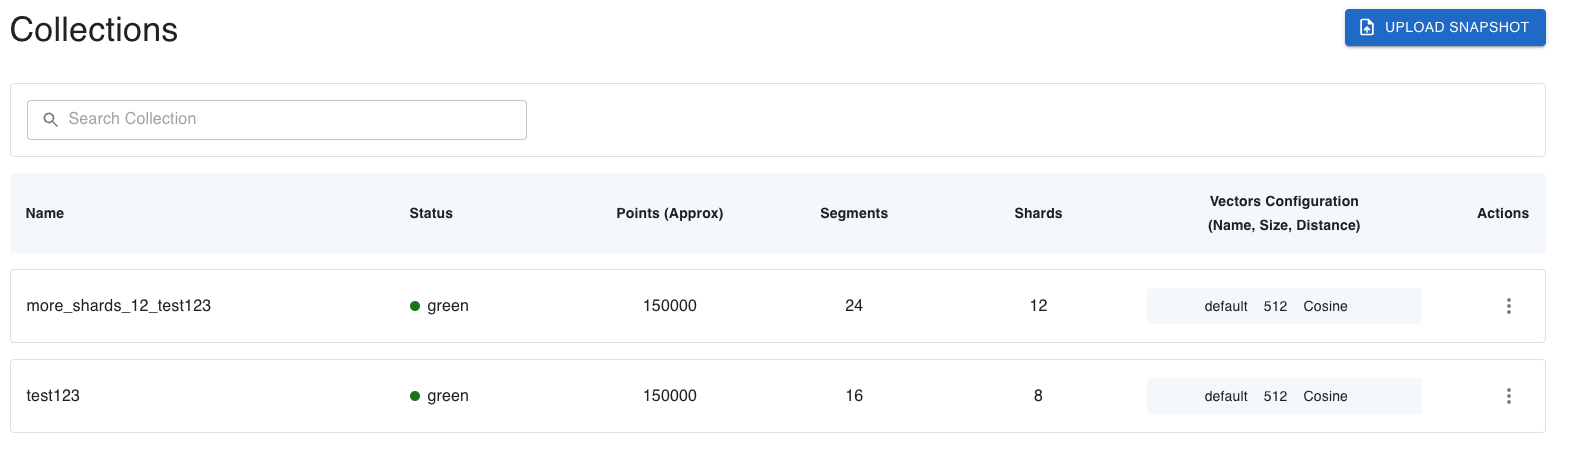